In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
import re,string

import json
import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

from sklearn.metrics import classification_report, confusion_matrix

from collections import Counter
from gensim.models import Word2Vec

seed_value = 42
import random
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()

In [3]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [4]:
df = pd.read_csv("cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

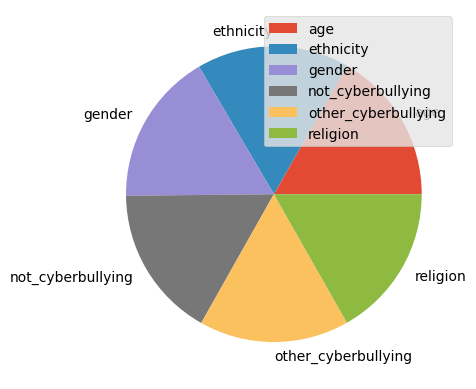

In [6]:
df.groupby('cyberbullying_type').size().plot(kind='pie')
plt.legend()

In [7]:
print('Number of Duplicates : ',df.duplicated().sum())
print('Shape before remove duplicates :',df.shape)
df=df.drop_duplicates()
print('Shape after  remove duplicates :',df.shape)

Number of Duplicates :  36
Shape before remove duplicates : (47692, 2)
Shape after  remove duplicates : (47656, 2)


In [8]:
class tweets_prepocessing_df:
    def __init__(self,text):
        text = text.to_frame()
        self.text = text['tweet_text']
    
    def remove_emoji(self,text):
        emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    def remove_url(self,text):
        text = re.sub(r"(?:\@|https?\://)\S+", " ", text)
        text = re.sub(r'[^\x00-\x7f]',r'', text)
        banned_list = string.punctuation
        text = text.translate(str.maketrans(' ',' ',banned_list))
        return text

    def remove_mult_spaces(self,text):
        return re.sub("\s\s+" , " ", text)
    
    def remove_stopwords(self,text):
        clean_text = []
        for el in word_tokenize(text):
            if not el in stop_words:
                clean_text.append(el)
        return clean_text

    def decontract(self,text):
        text = text.replace('\r',' ').replace('\n',' ').lower()
        text = re.sub(r"won\'t", " will not", text)
        text = re.sub(r"won\'t've", " will not have", text)
        text = re.sub(r"can\'t", " can not", text)
        text = re.sub(r"don\'t", " do not", text)
        text = re.sub(r"can\'t've", " can not have", text)
        text = re.sub(r"ma\'am", " madam", text)
        text = re.sub(r"let\'s", " let us", text)
        text = re.sub(r"ain\'t", " am not", text)
        text = re.sub(r"shan\'t", " shall not", text)
        text = re.sub(r"sha\n't", " shall not", text)
        text = re.sub(r"o\'clock", " of the clock", text)
        text = re.sub(r"y\'all", " you all", text)

        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"n\'t've", " not have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'d've", " would have", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ll've", " will have", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\'re", " are", text)
        return text

    def filter_chars(self,text):
        sent = []
        for word in text.split(' '):
            if ('$' in word) | ('&' in word):
                sent.append('')
            else:
                sent.append(word)
        return ' '.join(sent)
    
    def clean_hashtags(self,text):
        text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
        text = " ".join(word.strip() for word in re.split('#|_', text)) #remove hashtags symbol from words in the middle of the sentence
        return text

    def lemmatize(self,text):
        lemmatize_words = []
        for words in text:
            lemmatize_words.append(lem.lemmatize(words))
            # lemmatize_words.append(ps.stem(words))
        return ' '.join([word for word in lemmatize_words])
    
    def clean_data(self):
       self.text = self.text.apply(self.decontract)
       self.text = self.text.apply(self.remove_emoji)
       self.text = self.text.apply(self.remove_url)
       self.text = self.text.apply(self.clean_hashtags)
       self.text = self.text.apply(self.filter_chars)
       self.text = self.text.apply(self.remove_mult_spaces)
       self.text = self.text.apply(self.remove_stopwords)
       self.text = self.text.apply(self.lemmatize)
       return self.text
    

In [9]:
tpdf = tweets_prepocessing_df(df['tweet_text'])
df['clean_tweets'] = tpdf.clean_data()

In [10]:
df = df[df.cyberbullying_type!='other_cyberbullying']

In [11]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

In [12]:
text_len = []
for text in df.clean_tweets:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [13]:
df['text_len'] = text_len

In [14]:
df = df[df['text_len'] > 3]

In [15]:
max_len = np.max(df['text_len'])
max_len 

188

In [16]:
df['sentiment'] = df['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [17]:
X = df['clean_tweets']
y = df['sentiment']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [19]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5710],
       [   1, 5702],
       [   2, 5643],
       [   3, 5446],
       [   4, 4639]], dtype=int64)

In [20]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [21]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [22]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5710],
       [   1, 5710],
       [   2, 5710],
       [   3, 5710],
       [   4, 5710]], dtype=int64)

In [23]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    with open('ltsm_tokenize_2.json','w') as file:
        json.dump(vocab_to_int,file)


    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [24]:
vocabulary, tokenized_column = Tokenize(df['clean_tweets'], max_len)

In [25]:
df["clean_tweets"].iloc[10]


'love best response hotcake managed film noncommittal meh adolescent mkr'

In [26]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [27]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

In [28]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [29]:
EMBEDDING_DIM = 200

In [30]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [31]:
print(f"Vocabulary size: {len(vocabulary) + 1}")
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Vocabulary size: 41888


In [32]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (41888, 200)


In [33]:
X = tokenized_column
y = df['sentiment'].values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [36]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5710],
       [   1, 5702],
       [   2, 5643],
       [   3, 5446],
       [   4, 4639]], dtype=int64)

In [37]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train))

In [38]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5710],
       [   1, 5710],
       [   2, 5710],
       [   3, 5710],
       [   4, 5710]], dtype=int64)

In [39]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [40]:
BATCH_SIZE = 32

In [41]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [42]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [43]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 10 #Number of training epoch

EMBEDDING_DIM = 200

VOCAB_SIZE = 41888
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

c:\Users\nikhi\anaconda3\envs\tf25\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(41888, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [45]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [46]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './cyber_2_state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.320479).  Saving model ...
	Train_loss : 0.6658 Val_loss : 0.2319
	Train_acc : 75.018% Val_acc : 92.320%
Epoch 2:Validation accuracy increased (92.320479 --> 93.583777).  Saving model ...
	Train_loss : 0.1733 Val_loss : 0.1973
	Train_acc : 94.388% Val_acc : 93.584%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.1054 Val_loss : 0.2091
	Train_acc : 96.644% Val_acc : 92.786%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0698 Val_loss : 0.2606
	Train_acc : 97.905% Val_acc : 92.254%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0472 Val_loss : 0.2545
	Train_acc : 98.637% Val_acc : 91.622%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0336 Val_loss : 0.2839
	Train_acc : 99.047% Val_acc : 92.387%
Epoch 7:Validation accuracy did not increase
Early stopped at epoch : 7


In [47]:
model.load_state_dict(torch.load('./cyber_2_state_dict.pt'))

<All keys matched successfully>

In [48]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [49]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.96      0.95      0.95      1583
         age       0.99      0.97      0.98      1580
   ethnicity       0.98      0.98      0.98      1563
      gender       0.93      0.89      0.91      1509
not bullying       0.81      0.88      0.84      1285

    accuracy                           0.94      7520
   macro avg       0.93      0.93      0.93      7520
weighted avg       0.94      0.94      0.94      7520



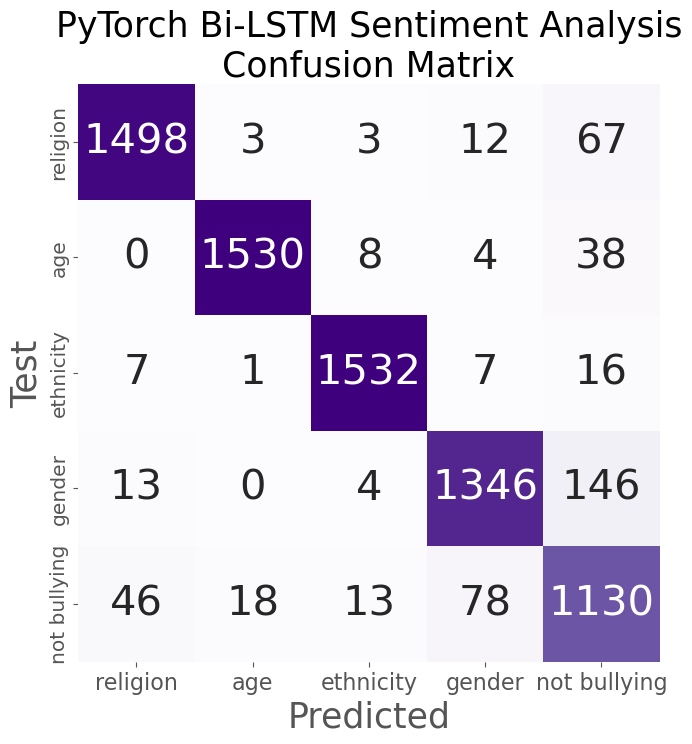

In [50]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

In [51]:
tested_value = pd.DataFrame({"Predicted Value":y_pred_list,"Actual Value":y_test_list})

In [52]:
wrong_prediction =  tested_value[tested_value['Predicted Value'] != tested_value['Actual Value']]
correct_prediction =  tested_value[tested_value['Predicted Value'] == tested_value['Actual Value']]


In [53]:
tested_value.shape[0] - len(wrong_prediction)

7036

In [54]:
tested_value.shape[0]

7520

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [56]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model.load_state_dict(torch.load('./cyber_state_dict.pt'))
model.to(device)

c:\Users\nikhi\anaconda3\envs\tf25\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(41888, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [57]:
model.eval()

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(41888, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [58]:
class preprocessing_input_text:
    def fit(self,text):
        self.text = text
        
    def __clean_hashtags(self):
        self.text = re.sub(r'\s*#\w+','',self.text)

    def __remove_emoji(self):
        emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        self.text = emoji_pattern.sub(r'', self.text)
    
    def __remove_url(self):
        banned_list = string.punctuation
        self.text = re.sub(r"(?:\@|https?\://)\S+", " ", self.text)
        self.text = re.sub(r'[^\x00-\x7f]',r'', self.text)
        self.text = self.text.translate(str.maketrans(' ',' ',banned_list))
        return self.text
    
    def __remove_stopwords(self):
        clean_text = []
        for el in word_tokenize(self.text):
            if not el in stop_words:
                clean_text.append(el)
        self.text = clean_text

    def __decontract(self):
        self.text = self.text.replace('\r',' ').replace('\n',' ').lower()
        self.text = re.sub(r"won\'t", " will not", self.text)
        self.text = re.sub(r"won\'t've", " will not have", self.text)
        self.text = re.sub(r"can\'t", " can not", self.text)
        self.text = re.sub(r"don\'t", " do not", self.text)
        
        self.text = re.sub(r"can\'t've", " can not have", self.text)
        self.text = re.sub(r"ma\'am", " madam", self.text)
        self.text = re.sub(r"let\'s", " let us", self.text)
        self.text = re.sub(r"ain\'t", " am not", self.text)
        self.text = re.sub(r"shan\'t", " shall not", self.text)
        self.text = re.sub(r"sha\n't", " shall not", self.text)
        self.text = re.sub(r"o\'clock", " of the clock", self.text)
        self.text = re.sub(r"y\'all", " you all", self.text)

        self.text = re.sub(r"n\'t", " not", self.text)
        self.text = re.sub(r"n\'t've", " not have", self.text)
        self.text = re.sub(r"\'re", " are", self.text)
        self.text = re.sub(r"\'s", " is", self.text)
        self.text = re.sub(r"\'d", " would", self.text)
        self.text = re.sub(r"\'d've", " would have", self.text)
        self.text = re.sub(r"\'ll", " will", self.text)
        self.text = re.sub(r"\'ll've", " will have", self.text)
        self.text = re.sub(r"\'t", " not", self.text)
        self.text = re.sub(r"\'ve", " have", self.text)
        self.text = re.sub(r"\'m", " am", self.text)
        self.text = re.sub(r"\'re", " are", self.text)

    def __filter_chars(self):
        sent = []
        for word in self.text.split(' '):
            if ('$' in word) | ('&' in word):
                sent.append('')
            else:
                sent.append(word)
        self.text =  ' '.join(sent)
    
    def __remove_mult_spaces(self):
        self.text = re.sub("\s\s+" , " ", self.text)
    
    def __lemmatize(self):
        lemmatize_words = []
        for words in self.text:
            lemmatize_words.append(lem.lemmatize(words))
        self.text =  ' '.join([word for word in lemmatize_words])

    def clean_data(self):
        self.__remove_emoji()
        self.__decontract()
        self.__remove_url()
        self.__clean_hashtags()
        self.__filter_chars()
        self.__remove_mult_spaces()
        self.__remove_stopwords()
        self.__lemmatize()
        return self.text


In [59]:
pit = preprocessing_input_text()
text = "rape is real..zvasiyana nema jokes about being drunk or being gay or being lesbian...rape is not ones choice or wish..thtz where the sensitivity is coming from"

In [60]:
pit.fit(text)
clean_input = pit.clean_data()

In [61]:
def Tokenize_input(input):
    seq_len =max_len
    vocab_to_init = []
    text_int = []

    with open('ltsm_tokenize_2.json','r') as file:
        vocab_to_init = json.load(file)
        
    r = [vocab_to_init[word] for word in input.split()]
    text_int.append(r)

    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
    
    return  np.array(features)


In [62]:
tokenize_inputs = Tokenize_input(clean_input)

In [63]:
torch.tensor(tokenize_inputs)

tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [64]:
text_loader = DataLoader(torch.from_numpy(tokenize_inputs),shuffle=True,batch_size=BATCH_SIZE,drop_last=True)

In [65]:
inputs_txt = torch.tensor(tokenize_inputs) 
inputs_txt = inputs_txt.to(DEVICE)

In [66]:
def predict():
    with torch.no_grad():
        h = model.init_hidden(1)
        output ,h = model(inputs_txt,h)
        return output.argmax(1)

In [67]:
test_h = model.init_hidden(labels.size(0))

In [68]:
predict()

tensor([3], device='cuda:0')

In [69]:
torch.tensor([0])

tensor([0])

In [70]:
len(torch.tensor(tokenize_inputs))

1

In [71]:
from torchviz import make_dot

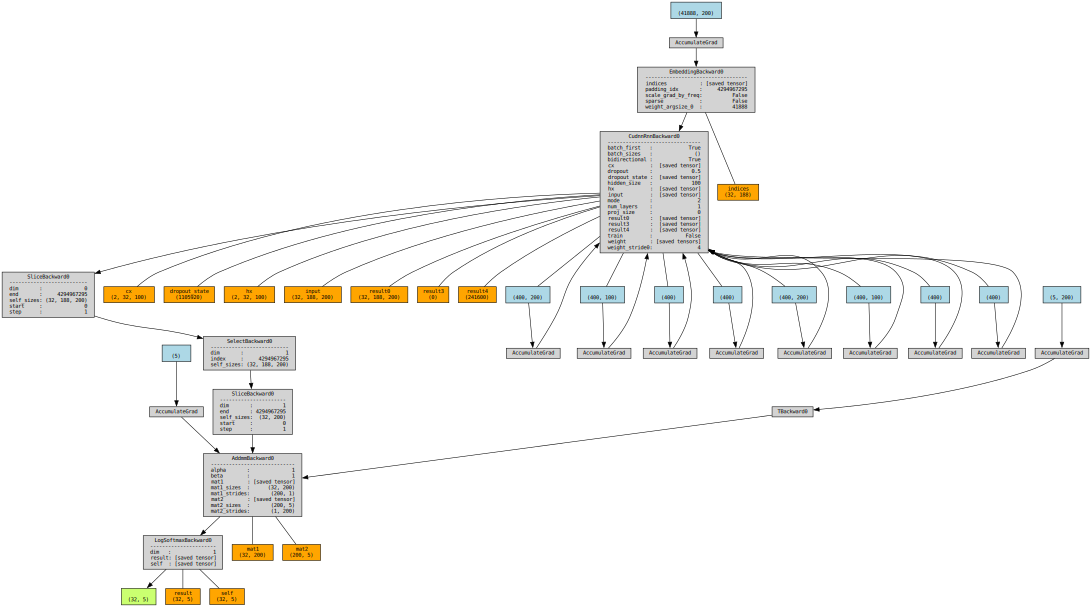

In [72]:
make_dot(output, params=dict(model.named_parameters()),show_attrs=True, show_saved=True)

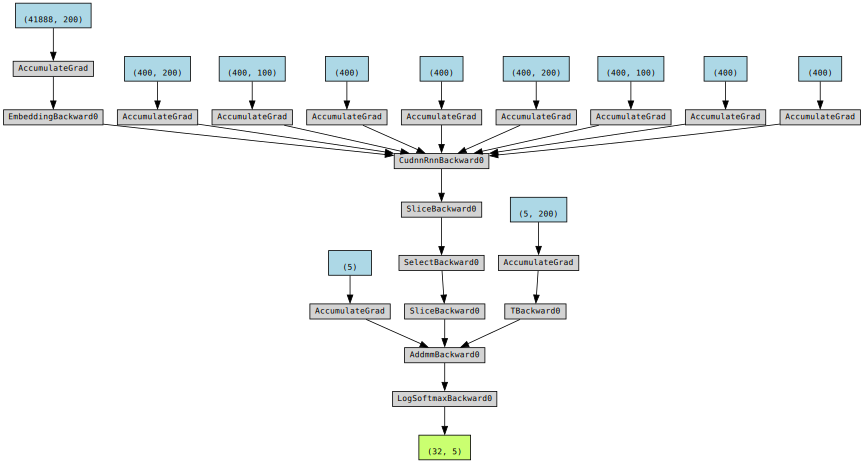

In [82]:
make_dot(output, params=dict(model.named_parameters()))

In [73]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [101]:
from torchsummary import summary

summary(model,(41888, 200))

TypeError: forward() missing 1 required positional argument: 'hidden'

In [84]:
h

(tensor([[[ 0.1244, -0.5123, -0.1709,  ...,  0.5807,  0.5026, -0.7535],
          [-0.0983,  0.7740, -0.7839,  ..., -0.4666, -0.6615,  0.0209],
          [ 0.4133,  0.8947, -0.3842,  ...,  0.8271, -0.6117,  0.5171],
          ...,
          [-0.6982, -0.9612, -0.1084,  ...,  0.1757,  0.3690,  0.9743],
          [ 0.6180,  0.9473, -0.2576,  ...,  0.8879, -0.5883,  0.4398],
          [ 0.3638, -0.2007,  0.2119,  ...,  0.8183, -0.2544,  0.0986]],
 
         [[ 0.0648,  0.1956,  0.2582,  ...,  0.2278, -0.0390,  0.2756],
          [ 0.0648,  0.1956,  0.2582,  ...,  0.2278, -0.0390,  0.2756],
          [ 0.0648,  0.1956,  0.2582,  ...,  0.2278, -0.0390,  0.2756],
          ...,
          [ 0.0648,  0.1956,  0.2582,  ...,  0.2278, -0.0390,  0.2756],
          [ 0.0648,  0.1956,  0.2582,  ...,  0.2278, -0.0390,  0.2756],
          [ 0.0648,  0.1956,  0.2582,  ...,  0.2278, -0.0390,  0.2756]]],
        device='cuda:0', grad_fn=<CudnnRnnBackward0>),
 tensor([[[ 0.2361, -0.6574, -0.2581,  ...,  1

In [85]:
h = model.init_hidden(1)

In [95]:
output

tensor([[-3.5918e+00, -8.2357e+00, -4.5987e+00, -1.2285e-01, -2.5546e+00],
        [-7.5725e+00, -1.9322e-03, -8.1752e+00, -1.1235e+01, -6.7934e+00],
        [-6.9358e+00, -7.5822e+00, -9.5296e+00, -3.7395e+00, -2.5647e-02],
        [-4.8944e+00, -7.8724e+00, -7.4121e+00, -2.0440e-01, -1.7351e+00],
        [-2.3815e-03, -7.2506e+00, -7.2360e+00, -7.2260e+00, -8.4161e+00],
        [-6.5401e+00, -1.1123e-02, -7.5690e+00, -9.3568e+00, -4.7089e+00],
        [-6.5581e+00, -1.0732e+01, -7.1148e+00, -4.2211e-03, -6.2354e+00],
        [-9.6608e+00, -1.1108e+01, -3.0632e-04, -8.4002e+00, -1.2780e+01],
        [-5.6452e-03, -6.2888e+00, -7.0552e+00, -6.5050e+00, -6.5618e+00],
        [-6.5221e+00, -1.0848e+01, -7.1119e+00, -5.1067e-03, -5.8823e+00],
        [-1.5166e-02, -7.1034e+00, -7.2677e+00, -5.3138e+00, -4.7550e+00],
        [-6.3578e+00, -3.5754e-02, -7.2302e+00, -8.4510e+00, -3.4280e+00],
        [-6.6664e+00, -1.1301e+01, -7.6894e+00, -5.1066e-03, -5.6986e+00],
        [-9.3911e-03, -7.

InvalidIndexError: (slice(None, None, None), 0)

In [106]:
df. iloc[:,0]

0        In other words #katandandre, your food was cra...
1        Why is #aussietv so white? #MKR #theblock #ImA...
2        @XochitlSuckkks a classy whore? Or more red ve...
3        @Jason_Gio meh. :P  thanks for the heads up, b...
4        @RudhoeEnglish This is an ISIS account pretend...
                               ...                        
47687    Black ppl aren't expected to do anything, depe...
47688    Turner did not withhold his disappointment. Tu...
47689    I swear to God. This dumb nigger bitch. I have...
47690    Yea fuck you RT @therealexel: IF YOURE A NIGGE...
47691    Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...
Name: tweet_text, Length: 37696, dtype: object